## Projeto 9

# Detecção de nuvens e sombra de nuvens:
## Informação espectral e metadados

Aline Casassola, Felipe Rafael de Sá Menezes Lucena e Grazieli Rodigheri

Instituto Nacional de Pesquisa Espacial (INPE) - 2020

Disciplina: SER-347

### Importação das bibliotecas usadas

In [24]:
# Importa a gdal, ogr e osr
from osgeo import gdal, ogr, osr

# Importa *
from gdalconst import *

# Uso de exceções
gdal.UseExceptions()

# Importa o matplotlib
import matplotlib.pyplot as plt

# Importa o Numpy
import numpy as np

# Importa os widgets
import ipywidgets as widgets

#Importa shape e mapping
from shapely.geometry import shape, mapping

import fiona
import math
import xml.etree.ElementTree as ET
import os

### Função que abre e retorna a imagem NIR do CBERS para calcular a máscara de nuvens:

In [25]:
# Função para abrir dataset:
def abrir_dataset (nome_arquivo):
    print ("Abrindo o arquivo: " + nome_arquivo)
    
    # Tenta abrir a imagem
    dataset = None
    try:
        dataset = gdal.Open(nome_arquivo, GA_ReadOnly)
        print("Arquivo aberto com sucesso!")
    except:
        print("Erro na abertura do arquivo!")
    
    return dataset

### Seleção da imagem pelo usuário

In [26]:
# Pedir pro usuário o caminho para a imagem:
lista_imagens = ['../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.tif']

# Cria um dropdown com a lista de imagens
nome_arquivo_NIR = widgets.Dropdown(
    options = lista_imagens
)

print ("Caminho do arquivo NIR:")
nome_arquivo_NIR

Caminho do arquivo NIR:


Dropdown(options=('../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.tif',), value='../…

### Abertura do dataset e conversão da banda NIR para array

In [27]:
# Abre a imagem NIR:
raster_NIR = abrir_dataset(nome_arquivo_NIR.value)

# Obtém a banda única do dataset
banda_NIR = raster_NIR.GetRasterBand(1)

# Transforma a banda em array
array_banda_NIR = banda_NIR.ReadAsArray()

Abrindo o arquivo: ../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.tif
Arquivo aberto com sucesso!


## Máscara de nuvens

### Selação do limiar pelo usuário

In [28]:
limiar = widgets.IntSlider( min=0, max=255, value=120, step=1)

limiar

IntSlider(value=120, max=255)

### Máscara em função do limiar

In [29]:
# Cria uma cópia da banda NIR para trabalhar
mascara_nuvens = np.copy(array_banda_NIR)

# Cria a máscara em função do limiar
mascara_nuvens[mascara_nuvens < limiar.value] = False
mascara_nuvens[mascara_nuvens >= limiar.value] = True

### Informações ao usuário

In [30]:
print("Estatísticas:")
print("")

print("Valores banda NIR:")
print("Min: ", array_banda_NIR.min())
print("Max: ", array_banda_NIR.max())
print("")

print("Valores máscara de Núvens:")
print("Min: ", mascara_nuvens.min())
print("Max: ", mascara_nuvens.max())
print("")

num_total_pixels = mascara_nuvens.size
print ("Número total de pixels:", num_total_pixels)

num_pixels_nuvem = len(mascara_nuvens[mascara_nuvens == 1])
print ("Número total de pixels com nuvens:", num_pixels_nuvem)

per_pixels_nuvem = (num_pixels_nuvem/num_total_pixels)*100
# per_pixels_nuvem = 80
print ("Percentual de pixels com nuvens:", (round(per_pixels_nuvem, 3)))

if (per_pixels_nuvem > 75):
    print("Céu totalmente coberto")
elif (per_pixels_nuvem > 20):
    print("Céu parcialmente coberto")
else:
    print("Céu limpo")

Estatísticas:

Valores banda NIR:
Min:  0
Max:  255

Valores máscara de Núvens:
Min:  0
Max:  1

Número total de pixels: 54788591
Número total de pixels com nuvens: 6703831
Percentual de pixels com nuvens: 12.236
Céu limpo


### Máscara de nuvens

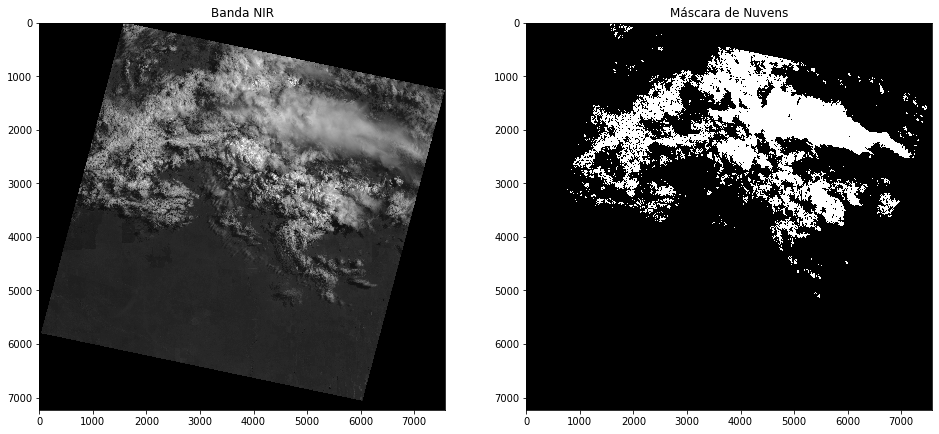

In [31]:
# Cria a figura
plt.figure(figsize = (16, 8))

# Mostra a imagem NIR
plt.subplot(121)
plt.title("Banda NIR")
plt.imshow(array_banda_NIR, cmap='gray');

# Mostra a máscara de nuvens
plt.subplot(122)
plt.title("Máscara de Nuvens")
plt.imshow(mascara_nuvens, cmap='gray');

### Salvando a máscara como arquivo tif

In [32]:
def salvar_banda(matriz_de_pixels, nome_do_arquivo, dataset_de_referencia):
    # Obtém as informações de tamanho do raster de referência
    linhas = dataset_de_referencia.RasterYSize
    colunas = dataset_de_referencia.RasterXSize
    bandas = 1
        
    # Carrega o driver para salvar tif
    driver = gdal.GetDriverByName('GTiff')
    
    # Obtém o tipo de dado do dataset de referência
    data_type = dataset_de_referencia.GetRasterBand(1).DataType
    
    # Criar novo dataset
    dataset_output = driver.Create(nome_do_arquivo, colunas, linhas, bandas, data_type)
    
    # Copiar informações espaciais da banda já existente
    dataset_output.SetGeoTransform(dataset_de_referencia.GetGeoTransform())
    
    # Copiar informações de projeção
    dataset_output.SetProjection(dataset_de_referencia.GetProjectionRef())
    
    # Escrever dados da matriz NumPy na banda
    dataset_output.GetRasterBand(1).WriteArray(matriz_de_pixels)
    
    # Salvar valores
    dataset_output.FlushCache()
    
    # Fechar dataset
    dataset_output = None

In [11]:
# Nome do arquivo de saída
nome_arquivo_mascara_destino = '../imagens/mascara_nuvens_CBERS_20180131.tif'

# Chama a função para salvar a máscara de nuvens
salvar_banda(mascara_nuvens, nome_arquivo_mascara_destino, raster_NIR)

## Máscara de sombras
### Abrindo a máscara de nuvens

In [33]:
# Abre a mascara de nuvem gerada anteriormente
nome_arquivo_mascara_nuvens = '../imagens/mascara_nuvens_CBERS_20180131.tif'

print ("Abrindo o arquivo: " + nome_arquivo_mascara_nuvens)

# Tenta abrir a imagem
try:
    mascara_nuvens = gdal.Open(nome_arquivo_mascara_nuvens, GA_ReadOnly)
    print("Arquivo aberto com sucesso!")
except:
    print("Erro na abertura do arquivo!")

Abrindo o arquivo: ../imagens/mascara_nuvens_CBERS_20180131.tif
Arquivo aberto com sucesso!


In [14]:
# Obtém a banda única do dataset
banda_mascara = mascara_nuvens.GetRasterBand(1)

# Transforma a banda em array
array_banda_mascara = banda_mascara.ReadAsArray()

### Gerando a máscara de sombras inicial (vetorização da máscara de nuvens)

In [16]:
## EPSG = int(osr.SpatialReference(wkt=mascara_nuvens.GetProjection()).GetAttrValue('AUTHORITY',1))
srs = osr.SpatialReference()
srs.ImportFromWkt(mascara_nuvens.GetProjectionRef())
# srs.ImportFromEPSG(EPSG)

shp_layername = '../shp/mascara_sombra_inicial'
driver = ogr.GetDriverByName("ESRI Shapefile")   
shp_datasource = driver.CreateDataSource(shp_layername + '.shp')
shp_layer = shp_datasource.CreateLayer(shp_layername, srs=srs)

new_field = ogr.FieldDefn('DN', ogr.OFTReal)
shp_layer.CreateField(new_field) 


gdal.Polygonize(banda_mascara, banda_mascara, shp_layer, 0, [], callback=None)

shp_datasource.Destroy()

### Deslocamento da máscara de nuvens a partir de um delta_x e delta_y

### Delta a partir dos metadados

In [18]:
tree = ET.parse('../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.xml')
root = tree.getroot()

image = root.find("{http://www.gisplan.com.br/xmlsat}image")
sun_incidence = root.find("{http://www.gisplan.com.br/xmlsat}sunIncidenceAngle")
degree_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}degree').text)
minute_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}minute').text)
second_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}second').text)

sun_incidence = degree_sun_incidence + minute_sun_incidence/60 + second_sun_incidence/3600

sun_position = image.find('{http://www.gisplan.com.br/xmlsat}sunPosition')
sun_azim = float(sun_position.find('{http://www.gisplan.com.br/xmlsat}sunAzimuth').text)
sun_zenith = float(sun_position.find('{http://www.gisplan.com.br/xmlsat}elevation').text)

sun_azim = math.radians(sun_azim)
sun_zenith = math.radians(sun_zenith)
view_azim = math.radians(0)
view_zenith = math.radians(0)

sen_sun_azi = math.sin(sun_azim)
cos_sun_azi = math.cos(sun_azim)
sen_view_azi = math.sin(view_azim)
cos_view_azi = math.cos(view_azim)
tan_sun_zenith = math.tan(sun_zenith)
tan_view_zenith = math.tan(view_zenith)

shadow_direction = math.pi + math.atan(sen_sun_azi*tan_sun_zenith-sen_view_azi*tan_view_zenith/
                                       (cos_sun_azi*tan_sun_zenith-cos_view_azi*tan_view_zenith))

h = 5000 # Altura das nuvens

shadow_distance = h * math.tan(math.radians(sun_incidence))

# shadow_distance2 = h * math.sqrt(
#     ( (sen_sun_azi*tan_sun_zenith) - (sen_view_azi*tan_view_zenith) )**2 +
#     ( (cos_sun_azi*tan_sun_zenith) - (cos_view_azi*tan_view_zenith) )**2
#     )

delta = (shadow_distance*math.cos(shadow_direction), shadow_distance*math.sin(shadow_direction))

### Deslocamento da máscara

In [20]:
# Essas três funções realizam o deslocamento das feições da camada. (Elas são recursivas entre si)
def movePoint_Coords(coords, delta):     # "delta" é uma tupla (delta_x, delta_y)
    return tuple(c + d for c, d in zip(coords, delta))
def moveLine_Coords(coords, delta):
    return list(movePoint_Coords(pt_coords, delta) for pt_coords in coords)
def movePolygon_Coords(coords, delta):
    return list(moveLine_Coords(ring_coords, delta) for ring_coords in coords)

with fiona.open('../shp/mascara_sombra_inicial.shp', "r") as shadow_cloud:

    with fiona.open("../shp/mascara_sombra_deslocada.shp", 
                    "w",
                    driver=shadow_cloud.driver,
                    schema=shadow_cloud.schema,
                    crs=shadow_cloud.crs) as moved_shadow:
        
        # Deslocamento de todas as feições da camada de máscara de nuvens vetorizada
        for feature in shadow_cloud:
            try:
                feature['geometry']['coordinates'] = movePolygon_Coords(feature['geometry']['coordinates'], delta)
                moved_shadow.write(feature)
            except:
                print("Error processing record %s:", feature)

### Subtração da mascara deslocada pela mascara de nuvens 

Observação: a intersecção entre a nuvem e a sombra deve ser removida, visto que não é somente sombra. Com a subtração, na máscara, permanece o que é exclusivamente sombra.

In [21]:
with fiona.open('../shp/mascara_sombra_inicial.shp', "r") as shadow_cloud:
    with fiona.open("../shp/mascara_sombra_deslocada.shp", "r") as moved_shadow:
        
        with fiona.open("../shp/mascara_sombra_final.shp", 
                    "w",
                    driver=shadow_cloud.driver,
                    schema=shadow_cloud.schema,
                    crs=shadow_cloud.crs) as dif:
            
            for i, j in zip(moved_shadow,shadow_cloud):
                
                # Corrigir erros topológico que impedem a subtração dos poligonos                
                polygons_source = shape(j['geometry'])
                polygons_shift = shape(i['geometry'])
                
                polygons_source_correct = polygons_source.buffer(0)
                polygons_shift_correct = polygons_shift.buffer(0)
                
                j['geometry'] = mapping(polygons_source_correct)
                i['geometry'] = mapping(polygons_shift_correct)
                #################################################################
            
                try:
                    difference = shape(i['geometry']).difference(shape(j['geometry']))
                    i['geometry'] = mapping(difference)
                    dif.write(i)
                except:
                    print("Error processing record %s:", i)

# Apagar arquivos shapefile auxiliares
driver.DeleteDataSource('../shp/mascara_sombra_deslocada.shp')
driver.DeleteDataSource('../shp/mascara_sombra_inicial.shp');